In [14]:
import pandas as pd
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
# Define file paths
train_csv = "/content/drive/MyDrive/Colab Notebooks/dataset/train.csv"
test_csv = "/content/drive/MyDrive/Colab Notebooks/dataset/test.csv"

# Load CSV files
train = pd.read_csv(train_csv, usecols=["image_ID", "label"])
test = pd.read_csv(test_csv, usecols=["image_ID"])

# Display shapes of train and test datasets
print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (8227, 2)
Test shape: (2056, 1)


In [16]:
image_to_label_map = dict(zip(train["image_ID"].values, train["label"].values))

unique_classes = train["label"].unique()
print("Unique classes:", unique_classes)
print("Number of unique classes:", len(unique_classes))

Unique classes: ['Badminton' 'Cricket' 'Tennis' 'Swimming' 'Soccer' 'Wrestling' 'Karate']
Number of unique classes: 7


<Axes: xlabel='label', ylabel='count'>

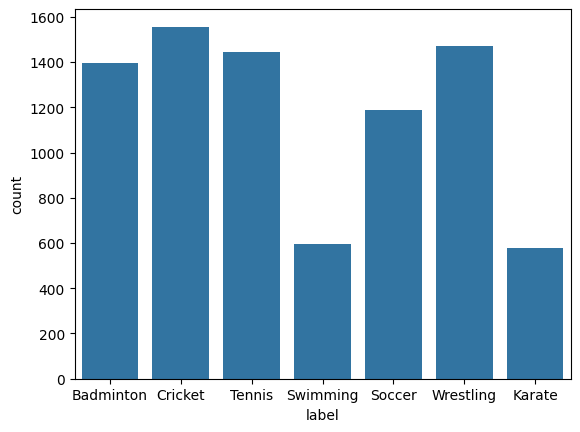

In [17]:
import seaborn as sns

sns.countplot(data=train, x="label")

In [18]:
label_counts = train["label"].value_counts()
print(label_counts)

label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


In [19]:
import os
import cv2
import numpy as np
from PIL import Image

def resample_minority_classes(train_df, output_dir="/content/drive/MyDrive/Colab Notebooks/dataset/train"):
    # Calculate the distribution of each class
    class_counts = train_df['label'].value_counts()

    # Identify the minority classes
    average_count = class_counts.mean()
    minority_classes = class_counts[class_counts < average_count].index
    print("Minority Classes:", minority_classes)

    # Filter the dataframe to get only minority class images
    minority_df = train_df[train_df['label'].isin(minority_classes)]

    # Create output directory in Google Drive if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    augmented_image_paths = []
    augmented_labels = []

    # Loop through minority class images and apply Gaussian Pyramid
    for idx in range(len(minority_df)):
        img_path = os.path.join("/content/drive/MyDrive/Colab Notebooks/dataset/train", minority_df.iloc[idx]['image_ID'])
        label = minority_df.iloc[idx]['label']

        # Load the image
        image = Image.open(img_path).convert("RGB")
        image_np = np.array(image)

        # Apply Gaussian Pyramid Downsampling
        image_np = cv2.pyrDown(image_np)

        # Save the augmented image to Google Drive
        base_filename = os.path.basename(img_path)
        augmented_path = os.path.join(output_dir, f"augmented_{base_filename}")
        cv2.imwrite(augmented_path, cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR))

        # Store augmented image path and label
        augmented_image_paths.append(augmented_path)
        augmented_labels.append(label)

    print("Resampling for minority classes completed.")

    # Create DataFrame for augmented images
    augmented_df = pd.DataFrame({
        'image_ID': augmented_image_paths,
        'label': augmented_labels
    })

    return augmented_df

# Create CSVs and resample minority classes
augmented_df = resample_minority_classes(train)

# Combine original train data and augmented data
combined_df = pd.concat([train, augmented_df], ignore_index=True)
combined_df.to_csv('/content/drive/MyDrive/Colab Notebooks/balanced_image_labels.csv', index=False)
print("Balanced dataset CSV created and saved in Google Drive.")

# Print the final distribution after combining
final_class_counts = combined_df['label'].value_counts()
print("Final Class Distribution After Combining All Data:\n", final_class_counts)

Minority Classes: Index(['Swimming', 'Karate'], dtype='object', name='label')
Resampling for minority classes completed.
Balanced dataset CSV created and saved in Google Drive.
Final Class Distribution After Combining All Data:
 label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Swimming     1190
Soccer       1188
Karate       1156
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

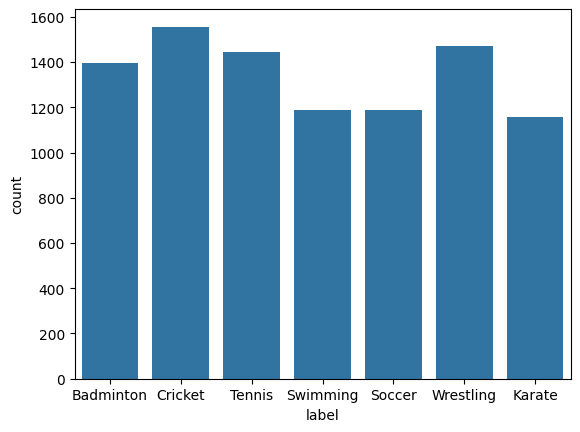

In [20]:
sns.countplot(data=combined_df, x="label")

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from torch.amp import GradScaler, autocast
from tqdm import tqdm

# Resnet50
# Dataset class for loading images and labels
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None, is_test=False):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.is_test or "label" not in self.dataframe.columns:
            return image  # No label available for test data
        label = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.long)
        return image, label


In [22]:
# 2. Split Data into Train and Validation Sets
combined_df['label'] = pd.Categorical(combined_df['label']).codes
train_df, val_df = train_test_split(combined_df, test_size=0.2, random_state=42)  # 80-20 split

# 3. Define Image Transformations
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 4. Define Image Directory Paths
train_img_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/train/"
test_img_dir = "/content/drive/MyDrive/Colab Notebooks/dataset/test/"

# 5. Create Datasets and Dataloaders
train_dataset = CustomImageDataset(train_df, train_img_dir, transform=transform)
val_dataset = CustomImageDataset(val_df, train_img_dir, transform=transform)  # Same dir if validation images are in `train`
test_dataset = CustomImageDataset(test, test_img_dir, transform=transform, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# 6. Model Setup
num_classes = len(train["label"].unique())
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjusting last layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

In [23]:
# Initialize GradScaler with updated syntax
scaler = GradScaler()

num_epochs = 5  # Set number of epochs

# Initialize lists to store metrics for each epoch
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    # Calculate accuracy and loss for the validation epoch
    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_model.pth")
        print("Model saved!")

# End of training
print("Training completed.")

Start training...


Epoch 1/5 - Training: 100%|██████████| 235/235 [09:19<00:00,  2.38s/it]


Epoch [1/5], Training Loss: 1.0208, Training Accuracy: 0.6544


Epoch 1/5 - Validation: 100%|██████████| 59/59 [02:20<00:00,  2.39s/it]


Epoch [1/5], Validation Loss: 1.0466, Validation Accuracy: 0.6207


Epoch 2/5 - Training: 100%|██████████| 235/235 [01:25<00:00,  2.75it/s]


Epoch [2/5], Training Loss: 0.6341, Training Accuracy: 0.7807


Epoch 2/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Epoch [2/5], Validation Loss: 0.7459, Validation Accuracy: 0.7415


Epoch 3/5 - Training: 100%|██████████| 235/235 [01:26<00:00,  2.72it/s]


Epoch [3/5], Training Loss: 0.4935, Training Accuracy: 0.8330


Epoch 3/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.82it/s]


Epoch [3/5], Validation Loss: 0.8085, Validation Accuracy: 0.7378


Epoch 4/5 - Training: 100%|██████████| 235/235 [01:26<00:00,  2.72it/s]


Epoch [4/5], Training Loss: 0.3743, Training Accuracy: 0.8739


Epoch 4/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.84it/s]


Epoch [4/5], Validation Loss: 0.5120, Validation Accuracy: 0.8330


Epoch 5/5 - Training: 100%|██████████| 235/235 [01:27<00:00,  2.69it/s]


Epoch [5/5], Training Loss: 0.3198, Training Accuracy: 0.8916


Epoch 5/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s]

Epoch [5/5], Validation Loss: 0.3860, Validation Accuracy: 0.8681
Training completed.


Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8800


In [24]:
# VGG

num_classes = len(train["label"].unique())

# Load VGG16 with pre-trained weights and modify the classifier layer
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Adjust the final layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 7. Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Initialize GradScaler for mixed precision training
scaler = GradScaler()

num_epochs = 5  # Set the number of epochs
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with VGG16...")

# 8. Training Loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_vgg16_model.pth")
        print("Model saved!")

print("Training with VGG16 completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 146MB/s]


Start training with VGG16...


Epoch 1/5 - Training: 100%|██████████| 235/235 [01:31<00:00,  2.56it/s]


Epoch [1/5], Training Loss: 1.9865, Training Accuracy: 0.1565


Epoch 1/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.82it/s]


Epoch [1/5], Validation Loss: 1.9484, Validation Accuracy: 0.1537


Epoch 2/5 - Training: 100%|██████████| 235/235 [01:31<00:00,  2.57it/s]


Epoch [2/5], Training Loss: 1.9465, Training Accuracy: 0.1582


Epoch 2/5 - Validation: 100%|██████████| 59/59 [00:22<00:00,  2.65it/s]


Epoch [2/5], Validation Loss: 1.9616, Validation Accuracy: 0.1622


Epoch 3/5 - Training: 100%|██████████| 235/235 [01:32<00:00,  2.54it/s]


Epoch [3/5], Training Loss: 1.9436, Training Accuracy: 0.1555


Epoch 3/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.84it/s]


Epoch [3/5], Validation Loss: 1.9591, Validation Accuracy: 0.1537


Epoch 4/5 - Training: 100%|██████████| 235/235 [01:31<00:00,  2.58it/s]


Epoch [4/5], Training Loss: 1.9447, Training Accuracy: 0.1638


Epoch 4/5 - Validation: 100%|██████████| 59/59 [00:21<00:00,  2.80it/s]


Epoch [4/5], Validation Loss: 1.9477, Validation Accuracy: 0.1436


Epoch 5/5 - Training: 100%|██████████| 235/235 [01:31<00:00,  2.57it/s]


Epoch [5/5], Training Loss: 1.9443, Training Accuracy: 0.1570


Epoch 5/5 - Validation: 100%|██████████| 59/59 [00:22<00:00,  2.63it/s]

Epoch [5/5], Validation Loss: 1.9475, Validation Accuracy: 0.1537
Training with VGG16 completed.


In [25]:
num_classes = len(train["label"].unique())

# Load GoogLeNet with pre-trained weights and modify the final layer
model = models.googlenet(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Adjust final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # Mixed precision training

# Training loop remains the same as in your existing code
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with GoogLeNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_googlenet_model.pth")
        print("Model saved!")

print("Training with GoogLeNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 178MB/s]


Start training with GoogLeNet...


Epoch 1/5 - Training: 100%|██████████| 235/235 [01:23<00:00,  2.81it/s]


Epoch [1/5], Training Loss: 0.5915, Training Accuracy: 0.7953


Epoch 1/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.93it/s]


Epoch [1/5], Validation Loss: 0.4197, Validation Accuracy: 0.8628


Epoch 2/5 - Training: 100%|██████████| 235/235 [01:24<00:00,  2.79it/s]


Epoch [2/5], Training Loss: 0.3419, Training Accuracy: 0.8848


Epoch 2/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.90it/s]


Epoch [2/5], Validation Loss: 0.2884, Validation Accuracy: 0.9059


Epoch 3/5 - Training: 100%|██████████| 235/235 [01:24<00:00,  2.77it/s]


Epoch [3/5], Training Loss: 0.2238, Training Accuracy: 0.9246


Epoch 3/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.87it/s]


Epoch [3/5], Validation Loss: 0.2506, Validation Accuracy: 0.9144


Epoch 4/5 - Training: 100%|██████████| 235/235 [01:24<00:00,  2.78it/s]


Epoch [4/5], Training Loss: 0.2018, Training Accuracy: 0.9348


Epoch 4/5 - Validation: 100%|██████████| 59/59 [00:20<00:00,  2.88it/s]


Epoch [4/5], Validation Loss: 0.3332, Validation Accuracy: 0.8894


Epoch 5/5 - Training: 100%|██████████| 235/235 [01:25<00:00,  2.75it/s]


Epoch [5/5], Training Loss: 0.1699, Training Accuracy: 0.9448


Epoch 5/5 - Validation: 100%|██████████| 59/59 [00:19<00:00,  3.01it/s]

Epoch [5/5], Validation Loss: 0.4637, Validation Accuracy: 0.8644
Training with GoogLeNet completed.


In [26]:
# AlexNet

# Set the number of classes for the final layer
num_classes = len(train["label"].unique())

# Load AlexNet with pre-trained weights and adjust the classifier for the number of classes
model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)  # Modify final fully connected layer

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
scaler = GradScaler()  # For mixed precision training

# Initialize lists to store metrics
num_epochs = 5
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

print("Start training with AlexNet...")

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast(device_type=device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate accuracy and loss for the training epoch
    train_loss = running_loss / total
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    val_running_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Step the learning rate scheduler
    scheduler.step()

    # Save model if it improves
    if val_accuracy > max(val_accuracies, default=0):
        torch.save(model.state_dict(), f"saved_models/sports_best_alexnet_model.pth")
        print("Model saved!")

print("Training with AlexNet completed.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 162MB/s]


Start training with AlexNet...


Epoch 1/5 - Training: 100%|██████████| 235/235 [01:18<00:00,  2.99it/s]


Epoch [1/5], Training Loss: 1.9471, Training Accuracy: 0.1723


Epoch 1/5 - Validation: 100%|██████████| 59/59 [00:19<00:00,  2.99it/s]


Epoch [1/5], Validation Loss: 1.8140, Validation Accuracy: 0.2415


Epoch 2/5 - Training: 100%|██████████| 235/235 [01:18<00:00,  2.98it/s]


Epoch [2/5], Training Loss: 3.7371, Training Accuracy: 0.1814


Epoch 2/5 - Validation: 100%|██████████| 59/59 [00:19<00:00,  3.10it/s]


Epoch [2/5], Validation Loss: 1.9467, Validation Accuracy: 0.1537


Epoch 3/5 - Training: 100%|██████████| 235/235 [01:21<00:00,  2.88it/s]


Epoch [3/5], Training Loss: 1.9406, Training Accuracy: 0.1653


Epoch 3/5 - Validation: 100%|██████████| 59/59 [00:19<00:00,  3.07it/s]


Epoch [3/5], Validation Loss: 1.9465, Validation Accuracy: 0.1452


Epoch 4/5 - Training: 100%|██████████| 235/235 [01:19<00:00,  2.97it/s]


Epoch [4/5], Training Loss: 1.9399, Training Accuracy: 0.1650


Epoch 4/5 - Validation: 100%|██████████| 59/59 [00:19<00:00,  3.04it/s]


Epoch [4/5], Validation Loss: 1.9460, Validation Accuracy: 0.1537


Epoch 5/5 - Training: 100%|██████████| 235/235 [01:20<00:00,  2.91it/s]


Epoch [5/5], Training Loss: 1.9397, Training Accuracy: 0.1660


Epoch 5/5 - Validation: 100%|██████████| 59/59 [00:18<00:00,  3.15it/s]

Epoch [5/5], Validation Loss: 1.9493, Validation Accuracy: 0.1537
Training with AlexNet completed.


Epoch [5/5], Training Loss: 1.8894, Training Accuracy: 0.1887 -> AlexNet  
Epoch [5/5], Training Loss: 0.1740, Training Accuracy: 0.9418-> googlenet  
Epoch [5/5], Training Loss: 1.1477, Training Accuracy: 0.5821 -> VGG16  
Epoch [5/5], Training Loss: 0.3478, Training Accuracy: 0.8800 -> Resnet50  

The dataset is probably very high in variability of features, moderately to greatly large in size with a great number of classes, and high-resolution images. The better performance by GoogLeNet and ResNet50 hints at complex and subtle patterns within the dataset that simpler models like AlexNet can't match.  

The dataset size is probably moderate to large: usually, the deeper models, like GoogLeNet and ResNet50, perform better when they have more data, which improves when using pre-trained weights. Similarly, the number of classes is probably big because, in this case, models like GoogLeNet handle the diversity among classes well, whereas AlexNet usually suffers in the multi-class environment.  

Finally, the dataset most likely contains high-resolution images (224x224 pixels or larger), as GoogLeNet and ResNet50 rely on detailed spatial information to distinguish complex features; this resolution allows deeper models to capture class-specific details—suggesting that GoogLeNet and ResNet50 would really be among the best choices for this dataset.  

